# b_model

## Experimental notes

In [50]:
from IPython.display import Image

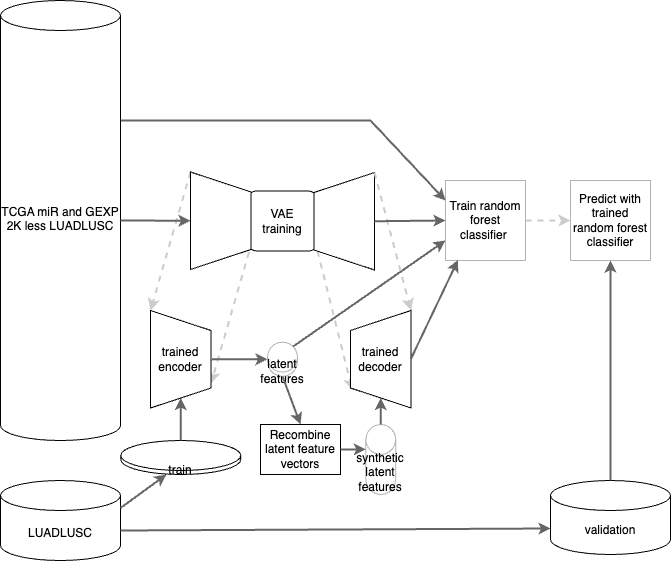

In [51]:
Image(filename='../g_learning_curves/luadlusc.png', width = 500)

In [ ]:
# 2023-01-09 Monday ^ aspirational goal; current devel on 
# same old no LGGGBM, MAD 5K fearure set

In [1]:
# From rep_0.7_luadlusc.ipynb, in g_learning_curves
# Begin g_line_curves experiment set
# Run 5 replicates on LUSC by 5pm Monday, January 9, 2023
# Simultaneous prep for 
# See notes / bookmarks on mesothelioma and uveal melanoma
    # BAP1 ubiquitin assiciated gene
    
# Molecular biology tie-in prep
# 2018 ten oncogenic pathways
# MSigDB - c4,6,etc.

In [ ]:
Léo Grinsztajn, 2022, NeurIPS
Why do tree-based models still outperform deep learning on typical tabular data?

In [27]:
pwd

'/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_line_curves'

In [28]:
ls

a_data.ipynb   b_model.ipynb  i_o/


In [32]:
ls ../g_learning_curves/i_o/

ACC_archive/                     latent feature inspect/
GEXP/                            latent_feature_objects/
GEXP_MAD_5k_across/              learning_curves/
GEXP_MAD_5k_across_no_LGGGBM/    loss_plots/
GEXP_MAD_5k_within/              ops_notes.txt
GEXP_MAD_5k_within_intersection/ rep_0.0/
GEXP_intersection/               rep_0.1/
GEXP_intersection_no_LGGGBM/     rep_0.2/
MIR/                             rep_0.3/
MSigDB/                          rep_0.4/
PDF_out/                         rep_0.5/
box_curve/                       rep_0.6/
box_whisk/                       rep_0.7/
bx_crv/                          shuffle/
bx_crv2/                         six_0.0/
bx_crv3/                         standard_deviation_plots/
bx_crv4/                         untitled.txt
decoded/                         val_0/
dim10/                           val_1/
dim100_run0/                     val_1.1/
figure_five/                     val_1.2/
lat_0.0/


In [ ]:
# Feature engineering to a_data

In [ ]:
# I_O setup for line curve dir
# add to gitignore

## Imports

In [20]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score
from statannot import add_stat_annotation

## VAE setup

In [21]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Directories

In [6]:
mkdir i_o

In [ ]:
# I_O setup for b_model, first iteratino in line dir

In [8]:
mkdir i_o/b_model

In [17]:
v = 'b_model'

In [ ]:
# directory setup for cobort_n to take b_model output

In [9]:
mkdir i_o/b_model/LUSC

In [10]:
ls i_o/b_model/LUSC

In [11]:
mkdir i_o/b_model/LUSC/decoded_objs

In [12]:
mkdir i_o/b_model/LUSC/front_end_box

In [13]:
mkdir i_o/b_model/LUSC/latent_objs

In [14]:
mkdir i_o/b_model/LUSC/learn_curve

In [15]:
mkdir i_o/b_model/LUSC/loss_plots

In [16]:
mkdir i_o/b_model/LUSC/take-off_points

In [18]:
ls i_o/b_model/LUSC

decoded_objs/    latent_objs/     loss_plots/
front_end_box/   learn_curve/     take-off_points/


## Read data / training protocol setup
Define pre-train and fine-tune sets

In [23]:
%whos

Variable                 Type               Data/Info
-----------------------------------------------------
Activation               type               <class 'keras.layers.core.activation.Activation'>
BatchNormalization       type               <class 'keras.layers.norm<...>tion.BatchNormalization'>
Callback                 type               <class 'keras.callbacks.Callback'>
CustomVariationalLayer   type               <class '__main__.CustomVariationalLayer'>
K                        TFModuleWrapper    <module 'tensorflow.compa<...>ras/backend/__init__.py'>
Layer                    type               <class 'keras.engine.base_layer.Layer'>
Model                    type               <class 'keras.engine.training.Model'>
RandomForestClassifier   ABCMeta            <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
WarmUpCallback           type               <class '__main__.WarmUpCallback'>
accuracy_score           function           <function accuracy_score at 0x28613ac10>
add_

In [33]:
file_paths_no_LGGGGBM = sorted(
    glob.glob(
        '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

In [ ]:
file_paths_no_LGGGGBM

In [35]:
len(file_paths_no_LGGGGBM)

25

In [36]:
TCGA_less_LGGGGBM_no_LUSC = ['../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 # '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 '../g_learning_curves/i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

In [ ]:
tall_stack = pd.DataFrame()
for path in TCGA_less_LGGGGBM_no_LUSC:
    print(path)
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

In [54]:
pre_train_file = tall_stack

In [37]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[12], # luadlusc are 11-13 depending on LGGGBM drop
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'LUSC'

## Validation threshold, storage frames, pre-flight checks

In [42]:
trn_size = 74

In [45]:
repeats = 10 # Front-end random forest repeats

In [47]:
inpt_val = pd.DataFrame()
lat_val = pd.DataFrame()
dec_val = pd.DataFrame()
synth_lat_val = pd.DataFrame()
synth_inpt_val = pd.DataFrame()
blend_inpt_synthFrmLat_val = pd.DataFrame()

In [38]:
v

'b_model'

In [40]:
ls i_o/ # Write feature engineering files into here (g_line_curves/i_o)

b_model/


In [59]:
fine_tune_file.Labels.value_counts()

LUSC_2    122
LUSC_1    119
LUSC_3     87
LUSC_5     44
LUSC_4     44
LUSC_6     44
Name: Labels, dtype: int64

## Replicates experimental start point

In [ ]:
# Start LUSC at replicate 1, 74 samples

In [43]:
val_split = 'vs01@'+str(trn_size)
trn = fine_tune_file.sample(trn_size)
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]
print(val_split)
if trn.Labels.value_counts().min() < 3:
    print('Undersampled subtype')
else:
    print('Good to go, minimum sample count is',trn.Labels.value_counts().min())

vs01@74
Good to go, minimum sample count is 6


In [60]:
trn.Labels.value_counts()

LUSC_2    20
LUSC_3    17
LUSC_1    15
LUSC_4     9
LUSC_6     7
LUSC_5     6
Name: Labels, dtype: int64

## Input validation

In [48]:
print('Start input validation with RF')
val_inpt_acrcy_lst = []
val_inpt_running_average = []

X_trn = trn.iloc[:, 1:]
y_trn = trn.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]

for r in list(range(0, repeats)):
    if r == 5:
        print('Half way to 10 rpts')    
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_inpt_acrcy_lst.append(val_raw_acc)
    val_inpt_running_average.append(mean(val_inpt_acrcy_lst))
inpt_val.insert(0, val_split, val_inpt_running_average)
print('Input transfer predictions complete')

Start input validation with RF
Half way to 10 rpts
Input transfer predictions complete


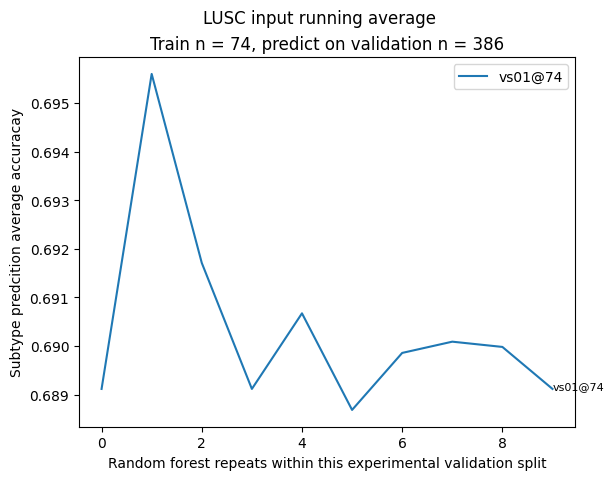

In [49]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input running average')
plt.title('Train n = '+str(
    len(trn))+', predict on validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE pre-training and fine-tuning

In [ ]:
# Re-pre-training the VAE for validation split (?)
# Solution: Run multiple pre-trainings with same validation split
# That's crazy. Is it worth it? Technical noise along with random forest stochasticity

Instructions for updating:
Colocations handled automatically by placer.
Metal device set to: Apple M1 Max


2023-01-09 14:59:38.978647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 14:59:38.978773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-09 14:59:38.982934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-09 14:59:38.986670: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-09 14:59:38.987285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 14:59:39.000290: I tensorflow/core/grappler/optimizers/custom_graph

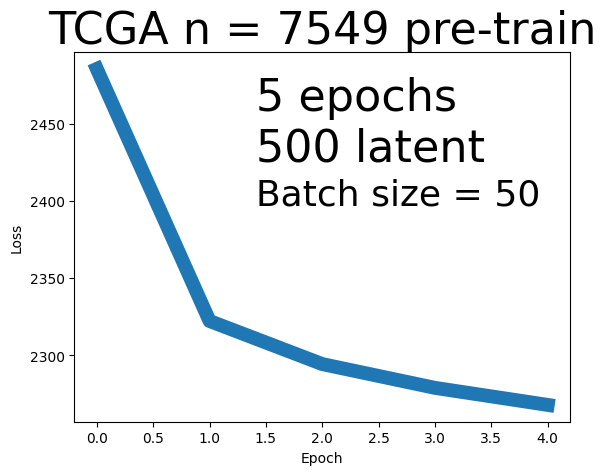

In [55]:
# Pre-train

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 500
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

pre_train_epochs = 5

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],
            epochs=pre_train_epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )
plt.annotate('Batch size = '+str(batch_size),        
            xy = (.4, .62), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on_file_write+'_epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+

    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

In [ ]:
# Looks ok, could try pre-train epoch counts in the range of 3-10

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-09 15:03:18.850084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 15:03:19.012195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


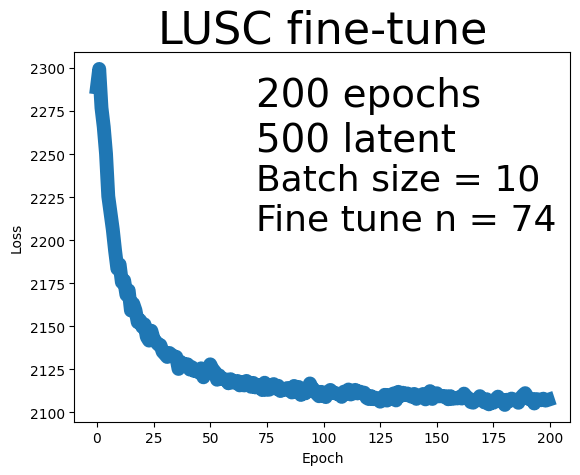

In [57]:
# Fine-tuning

train_file = trn
pre_trn = fit_on_file_write
fit_on = trn.index.name

fine_tune_epochs = 200
batch_size = 10

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],
            epochs = fine_tune_epochs, batch_size=batch_size, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',     
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 28
            )
plt.annotate('Batch size = '+str(batch_size)+
            '\nFine tune n = '+str(trn.shape[0]),             
            xy = (.4, .65), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])),
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index)
latent_object.index.name = trn.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/latent_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/decoded_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

## Latent validation

In [62]:
val_encoded = pd.DataFrame(encoder.predict(
    val.iloc[:, 1:]),
        index = val.index)
val_encoded_labeled = pd.concat(
    [pd.DataFrame(val.Labels),
     val_encoded] , axis =1)

In [63]:
# Latent to random forest
print('Latent validation start')
X_trn = latent_object.iloc[:, 1:]
y_trn = latent_object.iloc[:, 0]
X_val = val_encoded_labeled.iloc[:, 1:]
y_val = val_encoded_labeled.iloc[:, 0] 
val_lat_raw_acc_lst = []
val_lat_running_average = []
for r in list(range(0, repeats)):
    if r == 5:
        print('five done')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_lat_raw_acc_lst.append(val_raw_acc)
    val_lat_running_average.append(mean(val_lat_raw_acc_lst))
lat_val.insert(0, val_split, val_lat_running_average)
print('Latent validation complete')

Latent validation start
five done
Latent validation complete


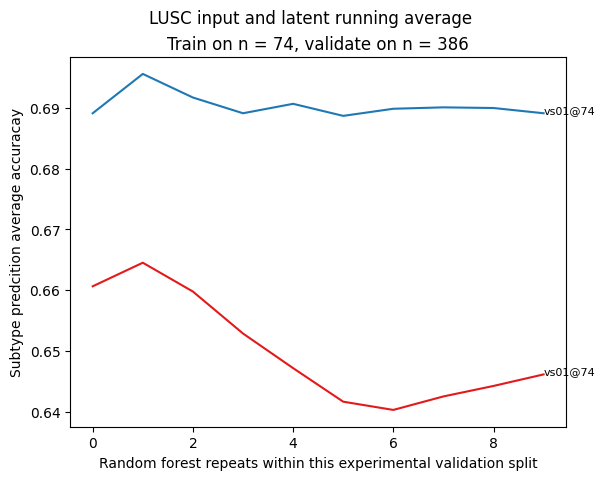

In [64]:
# Latent vs. input front-end plot
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')

plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Decoded validation

In [65]:
# Decoded validation
print('Decoded validation start')
X_trn = decoded_labeled.iloc[:, 1:]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

val_dec_raw_acc_lst = []
val_dec_running_average = []

for r in list(range(0, repeats)):
    if r == 5:
        print('half done') 
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_dec_raw_acc_lst.append(val_raw_acc)
    val_dec_running_average.append(mean(val_dec_raw_acc_lst))
dec_val.insert(0, val_split, val_dec_running_average)
print('Decoded validation complete')

Decoded validation start
half done
Decoded validation complete


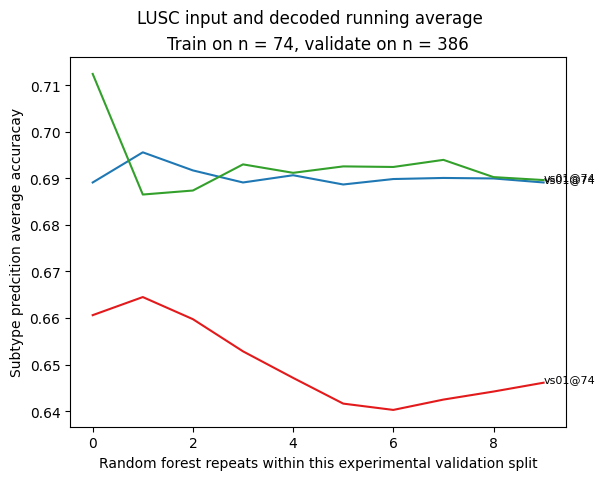

In [67]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input and decoded running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Synthetic sample generation

### Latent synthetic

In [58]:
# Three random real samples recombined per synthetic sample generated
print('Starting', val_split, 'synth gen from latent')
synth_in_count = 3
synth_sub_len = 100

synth_ndx_strt = 0
synth_full_frame = pd.DataFrame(columns = latent_object.columns)

for subtype in sorted(latent_object.Labels.unique()):  
    print(subtype)
    sub = latent_object[latent_object.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        input_sample_set = sub.sample(synth_in_count)
        new_samp_vec = []
        for col in input_sample_set.iloc[:, 1:]:
            vals_inpt = input_sample_set.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synth from latent, '+str(synth_sub_len)+' samples for each subtype')

Starting vs01@74 synth gen from latent
LUSC_1
100
LUSC_2
100
LUSC_3
100
LUSC_4
100
LUSC_5
100
LUSC_6
100
Synth from latent, 100 samples for each subtype


In [69]:
synth_lat_dec = pd.concat([synth_full_frame.iloc[:, 0],
                       pd.DataFrame(decoder.predict(synth_full_frame.iloc[:, 1:]), index = synth_full_frame.index)],
                     axis = 1)
synth_lat_dec.columns = trn.columns

In [70]:
# Validate synthetic: train on synthetic latent decoded, predict on validation

print('Synth latent validation start')
X_trn = synth_lat_dec.iloc[:, 1:] # Train on decoded synthetic latent
y_trn = synth_lat_dec.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

synth_lat_raw_acc_lst = []
synth_lat_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half')
    
    clf_trn = RandomForestClassifier() # Initialize classifier
    clf_trn.fit(X_trn, y_trn)
    synth_lat_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    synth_lat_raw_acc_lst.append(synth_lat_raw_acc) # Box plots
    synth_lat_running_average.append(mean(synth_lat_raw_acc_lst))
synth_lat_val.insert(0, val_split, synth_lat_running_average)
print('Synth latent complete')

Synth latent validation start
half
Synth latent complete


In [ ]:
# Maybe the fine-tune needs more epochs down in the flat of loss curve?

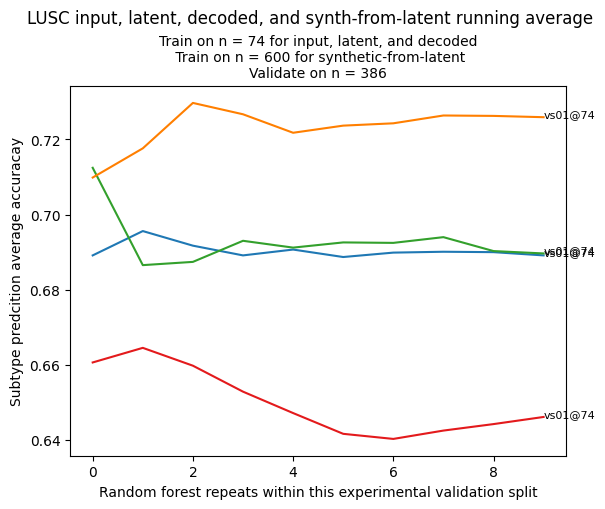

In [71]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]), fontsize = 8)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run, (9, synth_lat_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' input, latent, decoded, and synth-from-latent running average',
            y = 1.04)
plt.title('Train on n = '+str(
    len(trn))+' for input, latent, and decoded'+
          '\n Train on n = '+str(len(synth_lat_dec))+' for synthetic-from-latent'
          '\nValidate on n = '+str(
    len(val)), size = 10)
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
# Options: manually test fine-tune epochs
    # automate with shell scripts to check fine-tune epoch reduction
    # Put reinforcement agent to the experiment set up as environment

### Input synthetic

In [72]:
print('Starting', val_split, 'synth gen from input')
synth_ndx_strt = 0
synth_inpt_frame = pd.DataFrame(columns = latent_object.columns)
# synth_sub_len = 100 # Set in the latent sample generator, retain here
for subtype in sorted(trn.Labels.unique()):
    start = time.time()
    print(subtype)
    sub = trn[trn.Labels == subtype]
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        trpl = sub.sample(3)
        new_samp_vec = []
        for col in trpl.iloc[:, 1:]:
            vals_inpt = trpl.loc[:, col]
            choosen_val = vals_inpt.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_inpt_frame = pd.concat(
        [synth_inpt_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
    print('loop time: ', round(time.time() - start, 2))
print('Synth from input done, '+str(synth_sub_len)+' samples for each subtype')

Starting vs01@74 synth gen from input
LUSC_1
100
loop time:  21.61
LUSC_2
100
loop time:  21.13
LUSC_3
100
loop time:  21.13
LUSC_4
100
loop time:  21.15
LUSC_5
100
loop time:  21.22
LUSC_6
100
loop time:  21.26
Synth from input done, 100 samples for each subtype


In [73]:
synth_input_decoded = pd.DataFrame(decoder.predict(encoder.predict(synth_inpt_frame.iloc[:, 1:])),
                       index = synth_inpt_frame.index, columns = synth_inpt_frame.iloc[:, 1:].columns)
synth_input_decoded = pd.concat([synth_inpt_frame.iloc[:, 0], synth_input_decoded], axis = 1)
synth_input_decoded.columns = fine_tune_file.columns

In [74]:
# Synthetic samples from input val
print('Start synth input accuracy')
synth_input_raw_acc_lst = []
synth_input_running_average = []
X_trn = synth_input_decoded.iloc[:, 1:]
y_trn = synth_input_decoded.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0] 

for r in list(range(0, repeats)):
    if r == 5:
        print('5 repeats complete')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    
    synth_input_raw_acc_lst.append(raw_acc)
    synth_input_running_average.append(mean(synth_input_raw_acc_lst))
synth_inpt_val.insert(0, val_split, synth_input_running_average)
print('Input synth validation complete')

Start synth input accuracy
5 repeats complete
Input synth validation complete


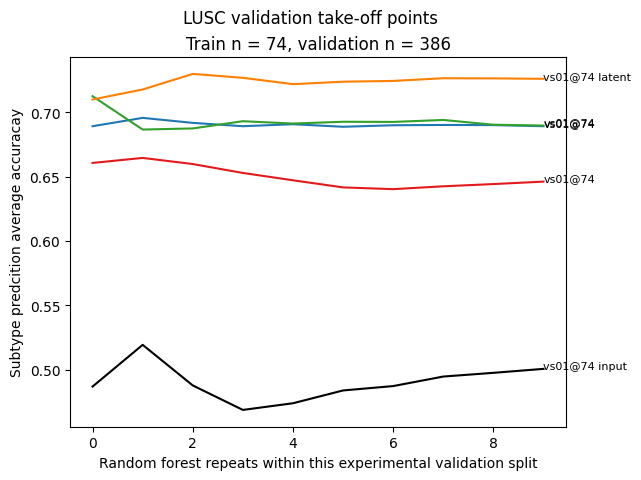

In [75]:
# Final interactive check plot
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]),fontsize = 8,)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run+' latent', (9, synth_lat_val[run][9]), fontsize = 8)
for run in synth_inpt_val.columns:
    plt.plot(synth_inpt_val[run], color = 'black', label = run)    
    plt.annotate(run+' input', (9, synth_inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' validation take-off points')
plt.title('Train n = '+str(
    len(trn))+', validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat+synthInp_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Line curve objects for plot

In [76]:
resmpl_count = 30 # Random forest runs per step size on the x-axis
                  # controls the error band

In [78]:
df_to_clf = trn
d_phs = 'input'
toggle_check = 'input done'
curve_range = list(range(10, trn_size+1, 5))

In [ ]:
# adding latent to function toggle
df_to_clf = latent_object

In [81]:
df_to_clf = decoded_labeled
d_phs = 'decoded'
toggle_check = 'decoded done'
curve_range = list(range(10, trn_size+1, 5))

In [85]:
upper_step = 30
outer_limits = 501
df_to_clf = synth_lat_dec
d_phs = 'lat_synth'
toggle_check = 'synthetic from latent done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [88]:
df_to_clf = synth_input_decoded
d_phs = 'inpt_synth'
toggle_check = 'synthetic from input done'
curve_range = list(range(trn_size, outer_limits, upper_step))

In [ ]:
# adding Blend to function toggle


In [89]:
# Line_curve_frame
accuracy_curve_frame = pd.DataFrame()
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
print(d_phs+' start')
for smp_sz in curve_range:

    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
    
print(toggle_check)

inpt_synth start
74
104
134
164
194
224
254
284
314
344
374
404
434
464
494
synthetic from input done


In [80]:
input_bx_crv = accuracy_curve_frame

In [83]:
decoded_bx_crv = accuracy_curve_frame

In [87]:
lat_synth_bx_crv = accuracy_curve_frame

In [90]:
inpt_synth_bx_crv = accuracy_curve_frame

In [ ]:
# Check out

In [ ]:
# LUSC devel fixesa

In [ ]:
# Blend zone
blend_to_clf = pd.concat([trn, synth_lat_dec],
                        axis = 0)
blend_to_clf.shaped_phs = 'blend_inp/synth.frm.ltnt'

toggle_check = 'blended done'
accuracy_curve_frame = pd.DataFrame()
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
print(d_phs+' start')
print('step size is '+str(upper_step))
for smp_sz in list(range(trn_size, outer_limits, upper_step)):
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = blend_to_clf.sample(smp_sz)
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
blend1_bx_crv = accuracy_curve_frame    
print(toggle_check)

In [ ]:
line_curve_frame = pd.concat(
    [input_ln_crv,
     latent_ln_crv,
     decoded_ln_crv,
     
     lat_synth_ln_crv,
     inpt_synth_ln_crv,
    blend1_ln_crv] ,
    axis = 0)

In [84]:
val_split

'vs01@74'

In [ ]:
line_curve_frame['Validation_split'] = val_split

In [ ]:
# Add max input (blue) dashed line and value annotation
# Add max synthetic value annotation and line 

In [ ]:
# Line curves
figure(figsize=(6, 6), dpi=150)
palette=['blue', 'red','green',
         plt.cm.Paired(7), 'orange', '#b05107']

phase_list = ['input', 'latent', 'decoded',
              'lat_synth', 'inpt_synth', 'blend_inp/synth.frm.ltnt']

ax = sns.lineplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=line_curve_frame, linewidth = .5)
    
plt.suptitle(trn.index.name+' learning curves, '+'TCGA pre-train'+
            '\nReplicate '+val_split)
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'_line.png', bbox_inches = 'tight')
print(val_split+' done')

## Front-end box

In [ ]:
my_pal = {'input': plt.cm.Paired(1),
          'decoded': plt.cm.Paired(3),
          'latent_synth': plt.cm.Paired(7),
          'input_synth': 'orange'}

# figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(summ, x='Take-off_point', y='Accuracy',
           palette = my_pal)

# add_stat_annotation(ax,
#                     data=summ,
#                     x='Take-off_point',
#                     y='Accuracy',
#                     # order=order,
#                     box_pairs=[('input', 'decoded'),
#                               ('input', 'latent_synth'),
#                               ('input', 'input_synth')
#                               ],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.suptitle(trn.index.name+' direct train and decode, five replicates')
plt.title('Train set n = '+str(len(trn))+' validation set n = '+str(len(val)),
         fontsize = 10)
plt.savefig('i_o/'+v+'/'+trn.index.name+'_front_end_direct_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')